In [10]:
import sys
sys.path.insert(0, '../..')

#Import the usual libraries


from tqdm import tqdm
import time
import scipy
import os
import numpy as np
import scanpy as sc
import pandas as pd

#Data
from ggml.generator import get_pointcloud, create_t_triplets
from ggml.data_loader import scRNA_Dataset, get_cells_by_patients_2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Global and Ground Metrics
from ggml.ggml import ggml 
from ggml.distances import pairwise_mahalanobis_distance, pairwise_mahalanobis_distance_npy
from sklearn.metrics.pairwise import pairwise_distances
import ot

#Classification
from ggml.benchmark import knn_from_dists, plot_table, plot_1split


#Plotting
from ggml.plot import plot_distribution, plot_emb, hier_clustering, plot_ellipses
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
demo = True

#GGML Hyperparams
# You can compute multiple configurations with one run, here we have selected the chosen hyperparams for the myocardial infarction dataset.
neighbor_t = [3]
rank_k = [5] 
alphas = [1] 
lambdas = [10] 

lr = 0.01
dia_only = False #Only allows to scale variances and not covariances

#Data
dataset_folder = "/home/kuehn/ot_metric_learning/damin-ggml/data/datasets/"
disease = "myocard_infarct"
n_cells = 1000 
train_split = 0.6
splits = 1 if demo else 10

pca_comps = None #instead of learning in the gene space we can also learn on PCA components
filter_highvar_genes = True 

#Processing
n_threads = 100
iterations= 50
plot_every_i_iterations = 5
save_every_i_iterations = 10

In [12]:
if disease == "myocard_infarct":
    #Myocardial infarction
    dataset_name = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
    disease = "myocard_infarct"
    patient_col="sample"
    label_col="major_labl"  

elif disease == "kidney":
    #Kidney
    disease = "kidney"
    dataset_name = "1c360b0b-eb2f-45a3-aba9-056026b39fa5.h5ad" #"5ccb0043-bb6f-4f00-b7e1-526d2726de9d.h5ad"
    label_col="disease"
    patient_col="donor_id"

elif disease == "breastcancer":
    #Breastcancer
    disease = "breastcancer"
    dataset_name = "b8b5be07-061b-4390-af0a-f9ced877a068.h5ad"
    label_col="reported_diseases"
    patient_col="donor_id"

In [13]:
training_data = {}
train_dataset = {}

for a in alphas:
    for l in lambdas:
        for t in neighbor_t:
                for k in rank_k:
                        training_data[(a,l,t,k)] = scRNA_Dataset(dataset_folder+dataset_name,patient_col=patient_col,label_col=label_col,n_cells=n_cells,n_feats=pca_comps,filter_genes=filter_highvar_genes,t=t,subsample_patient_ratio=train_split)
                        train_dataset[(a,l,t,k)] = DataLoader(training_data[(a,l,t,k)], batch_size=128, shuffle=True)


Removed 21198 low variance genes out of 28975 genes
passed neighs: 3


In [14]:
'''
train_features, train_labels = next(iter(train_dataset))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


trpl_distributions = train_features[0]
trpl_label = train_labels[0]


plot_distribution(trpl_distributions,trpl_label)

plt.show()
print(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")
'''

'\ntrain_features, train_labels = next(iter(train_dataset))\nprint(f"Feature batch shape: {train_features.size()}")\nprint(f"Labels batch shape: {train_labels.size()}")\n\n\ntrpl_distributions = train_features[0]\ntrpl_label = train_labels[0]\n\n\nplot_distribution(trpl_distributions,trpl_label)\n\nplt.show()\nprint(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")\n'

In [15]:
results = {}
thetas = {}
times = {}

In [ ]:
%load_ext autoreload
%autoreload 2

for a,l,t,k in train_dataset.keys():
    if (a,l,t,k) in times.keys():
        continue
    
    w_theta, time = ggml(train_dataset[(a,l,t,k)],alpha=a,lambda_=l,rank_k=k,neigh_t=t,lr=lr,iterations=iterations,plot_every_i_iterations=plot_every_i_iterations,full_dataset_for_plotting=training_data[(a,l,t,k)],save_every_i_iterations=save_every_i_iterations,n_threads=n_threads)

    thetas[(a,l,t,k)]= w_theta.clone().detach().numpy()
    times[(a,l,t,k)] = time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#Print averaege epoch time for different rank k and neighs. t
table = np.zeros((len(rank_k),len(neighbor_t)))

for a,l,t,k in times.keys():
    #print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}")
    table[rank_k.index(k),neighbor_t.index(t)] = np.average(times[(a,l,t,k)])

print(table)



table_df = pd.DataFrame(data=table,index=rank_k,columns=neighbor_t).transpose()


display(table_df)
print(table_df.to_latex(index=True,
                #formatters={"name": str.upper},
                float_format="{:.1f}".format,
))

[[1176.49686456]]


,5
3,1176.496865


\begin{tabular}{lr}
\toprule
 & 5 \\
\midrule
3 & 1176.5 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrr}
\toprule
 & 5 & 10 & 50 & 100 & 200 \\
\midrule
1 & 12.9 & 14.5 & 15.8 & 17.0 & 22.3 \\
3 & 130.4 & 132.5 & 143.3 & 156.0 & 195.8 \\
5 & 348.6 & 361.3 & 365.2 & 417.3 & 525.4 \\
7 & NaN & 687.6 & 789.3 & 866.7 & 1040.5 \\
9 & 1049.1 & 1119.8 & 1249.2 & 1446.2 & 1703.2 \\
\bottomrule
\end{tabular}



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[-0.8483193   -0.7749758    0.8663573   ... -0.27737245  -0.4423701
  -0.35356656 ]
 [ 0.3523178   -0.6059981   -0.34605408  ...  0.22243632   0.36361015
   0.3857062  ]
 [ 0.99987096   0.41386867  -0.9079424   ...  0.6381111   -0.036557876
   0.51241326 ]
 [-0.6138765   -0.20850286   0.057052575 ... -0.868161    -0.77564144
   0.3445888  ]
 [ 0.20379125   0.8255113   -0.62510234  ...  0.5720052    0.40284753
   0.85374695 ]]


NameError: name 'plot_w_theta' is not defined

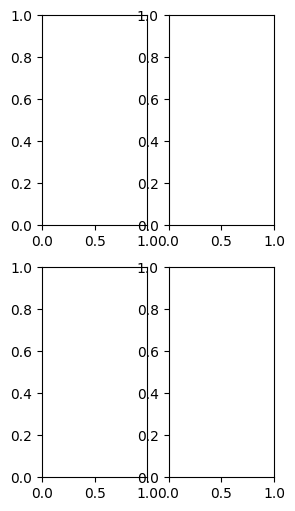

In [ ]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True,precision=16)
np.save("/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/w_theta.npy",w_theta.clone().detach().numpy())
print(w_theta.clone().detach().numpy())
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3,6))


#fig, ax = plt.subplots(figsize=(3,3))
ax = plot_w_theta(np.identity(2), ax=axs[0,0])
print(ax)
ax.set_title(r'Euclidean $d_2$ (Baseline)')
ax.get_figure().set_size_inches(4.8,5)

ax = plot_w_theta(w_theta.clone().detach().numpy(), ax=axs[1,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (GGML)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(M=np.asarray([[9.85031407, 0.02607956],
       [0.02607956, 0.07327278]]), ax=axs[0,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (NCA)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(np.asarray([[1,0],[0,0]]), ax=axs[1,0])
print(ax)
ax.set_title(r'Groundtruth $d^*$')
#ax.get_figure().set_size_inches(2.4,5)

plt.tight_layout()
plt.show()
from matplotlib.pyplot import figure

figure(figsize=(3, 3), dpi=80)

training_data.compute_OT_on_dists(w = w_theta.clone().detach().numpy(),legend=None)


[  0.                  2.16                4.32
   6.48                8.64               10.8
  12.96               15.120000000000001  17.28
  19.44               21.6                23.76
  25.92               28.080000000000002  30.240000000000002
  32.400000000000006  34.56               36.72
  38.88               41.040000000000006  43.2
  45.36               47.52               49.68000000000001
  51.84               54.                 56.160000000000004
  58.32000000000001   60.480000000000004  62.64
  64.80000000000001   66.96000000000001   69.12
  71.28               73.44               75.60000000000001
  77.76               79.92               82.08000000000001
  84.24000000000001   86.4                88.56
  90.72               92.88000000000001   95.04
  97.2                99.36000000000001  101.52000000000001
 103.68              105.84              108.
 110.16000000000001  112.32000000000001  114.48
 116.64000000000001  118.80000000000001  120.96000000000001
 123.1

ValueError: x and y must have same first dimension, but have shapes (100,) and (18,)

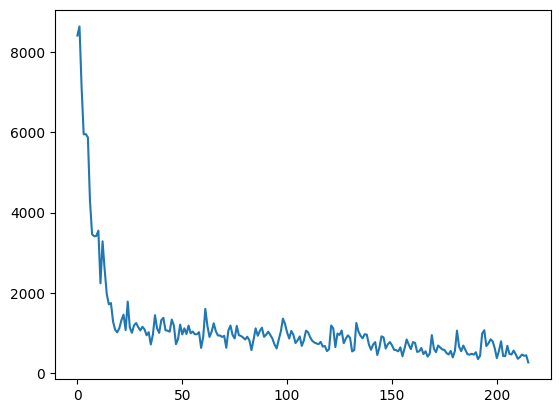

: 

: 

: 

In [ ]:
t = np.arange(len(losses))
datapoints_per_iteration = len(losses)/iterations
t2 = np.arange(0,len(losses),datapoints_per_iteration)
print(t2)
print(len(iteration_losses_total))
print(w_theta)
#fig, ax = plt.subplots()
plt.plot(t, losses, label = "loss minibatches")
plt.plot(t2, [l/datapoints_per_iteration for l in iteration_losses_total], label = "average loss iteration")
plt.legend() 




#print(total_loss_best_theta)


In [ ]:
for p1 in 

SyntaxError: invalid syntax (2993858587.py, line 1)

: 

: 

: 